In [3]:
pip install tensorflow==2.18.0

  Using cached absl_py-2.2.2-py3-none-any.whl.metadata (2.6 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached requests-2.32.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached termcolor-3.1.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached tensorboard-2.18.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.10.0-py3-none-any.whl.metadata (6.0 kB)
  Using cached tensorflow_io_gcs_filesystem-0.31.0-cp39-cp39-win_amd64.whl.metadata (14 kB)
  Using cached idna-3.10-py3-none-any.whl.metadata (10 kB)
  Using cached urllib3-2.4.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached certifi-2025.4.26-

In [7]:
!pip install scikit-learn

   ---------------------------------------- 0.0/11.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.2 MB 2.8 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/11.2 MB 3.9 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.2 MB 4.8 MB/s eta 0:00:02
   --------------- ------------------------ 4.5/11.2 MB 5.8 MB/s eta 0:00:02
   ---------------------------- ----------- 7.9/11.2 MB 8.0 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.2 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------  11.0/11.2 MB 9.6 MB/s eta 0:00:01
   ---------------------------------------- 11.2/11.2 MB 7.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ---- ----------------------------------- 5.2/46.2 MB 29.0 MB/s eta 0:00:02
   --------- ------------------------------ 11.0/46.2 MB 25.5 MB/s eta 0:00:02
   --------------- ------------------------ 17.8/46.2 MB 24.4 MB/s eta 0:00:02
   --

##  Résumé du Code : Préparation des Données Vidéo pour la Détection de Chutes

Ce script a pour but de **préparer les données d'entraînement** pour un modèle de **prédiction de chutes** à partir de vidéos.

---

###  Étapes Clés :

-  **Chargement des vidéos** à partir de deux dossiers :
  -  Vidéos de **chutes** → `label = 0`
  -  Vidéos **normales** → `label = 1`

-  **Extraction de 30 images** (frames) par vidéo

-  **Redimensionnement des images** à `128 × 128` pixels

-  **Création des séquences** de données et **encodage des labels** en **one-hot**

-  **Division des données** :
  - **95%** pour l'entraînement  
  - **5%** pour les tests

---

In [10]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

TensorFlow version: 2.18.0
Keras version: 3.10.0


In [11]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
# Paramètres
SEQUENCE_LENGTH = 30
IMG_SIZE = (128, 128) 
TEST_RATIO = 0.05
# Chemins
VIDEO_PATH_CHUTES = r"../data/dataAlgorithme1/VideoChute"
VIDEO_PATH_NORMAUX = r"../data/dataAlgorithme1/videoNormal"
def extract_frames(video_path, num_frames=SEQUENCE_LENGTH):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < num_frames and cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = cv2.resize(frame, IMG_SIZE)
        frames.append(frame)
    cap.release()
    return np.array(frames[:num_frames])
# Chargement des données
X, y = [], []
# Vidéos de chute (label 0)
for video_file in os.listdir(VIDEO_PATH_CHUTES):
    video_path = os.path.join(VIDEO_PATH_CHUTES, video_file)
    sequence = extract_frames(video_path)
    if len(sequence) == SEQUENCE_LENGTH:
        X.append(sequence)
        y.append(0)
# Vidéos normales (label 1)
for video_file in os.listdir(VIDEO_PATH_NORMAUX):
    video_path = os.path.join(VIDEO_PATH_NORMAUX, video_file)
    sequence = extract_frames(video_path)
    if len(sequence) == SEQUENCE_LENGTH:
        X.append(sequence)
        y.append(1)
# Conversion et split
X = np.array(X)
y = to_categorical(np.array(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_RATIO, stratify=y)
print(f"Données préparées : {X_train.shape} (train), {X_test.shape} (test)")

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '../data/dataAlgorithme1/VideoChute'

# 🔹  Construction du Modèle
---

# 🔹  Explication détaillée du modèle de détection de chute
---

### 🔹  Import des librairies
On importe les fonctions nécessaires pour construire, entraîner et évaluer le modèle :  
`Sequential`, `TimeDistributed`, `Conv2D`, `MaxPooling2D`, `BatchNormalization`, `LSTM`, `EarlyStopping`, `matplotlib` et `numpy`.

---

### 🔹  Architecture du modèle
- **TimeDistributed Conv2D (32 filtres, 3x3)** : applique une couche convolutionnelle à chaque image de la séquence.  
- **TimeDistributed BatchNormalization** : normalise les activations pour stabiliser l’entraînement.  
- **TimeDistributed MaxPooling2D** : réduit la taille des images en gardant les infos importantes.  
- **TimeDistributed Dropout(0.5)** : évite le sur-apprentissage en désactivant aléatoirement 50% des neurones.  
- **TimeDistributed Conv2D (64 filtres, 3x3)** : extraie des caractéristiques plus complexes.  
- **TimeDistributed GlobalMaxPooling2D** : convertit chaque image en un vecteur compact.  
- **LSTM(128, return_sequences=True)** : apprend les dépendances temporelles en sortie pour chaque image.  
- **LSTM(64)** : résume la séquence en un vecteur global.  
- **Dense(32, activation='relu')** : apprend des combinaisons non linéaires.  
- **Dense(2, activation='softmax')** : sortie finale avec probabilités pour les 2 classes.

---

### 🔹  Compilation du modèle
- `loss='categorical_crossentropy'` : adaptée à la classification multiclasse.  
- `optimizer='adam'` : optimise efficacement le modèle.  
- `metrics=['accuracy']` : suit la précision du modèle.

---

### 🔹  Entraînement
- Utilisation des données `X_train`, `y_train` avec validation sur `X_test`, `y_test`.  
- `epochs=50`, `batch_size=8`.  
- `EarlyStopping` pour arrêter si la perte de validation ne s’améliore pas après 10 époques.

---

### 🔹  Visualisation des résultats
Affiche les courbes d’accuracy sur l’entraînement et la validation pour suivre l’apprentissage.

---

### 🔹  Évaluation finale
- Prédictions sur `X_test`.  
- Calcul et affichage de la matrice de confusion pour mesurer la performance en détail.

---


2/2




















Epoch 1/50
6/6 [==============================] - 96s 11s/step - loss: 0.7182 - accuracy: 0.5417 - val_loss: 0.6295 - val_accuracy: 0.9231
Epoch 2/50
6/6 [==============================] - 59s 10s/step - loss: 0.6655 - accuracy: 0.5417 - val_loss: 0.5912 - val_accuracy: 0.8462
Epoch 3/50
6/6 [==============================] - 63s 10s/step - loss: 0.6049 - accuracy: 0.7917 - val_loss: 0.5706 - val_accuracy: 0.5385
Epoch 4/50
6/6 [==============================] - 49s 8s/step - loss: 0.5457 - accuracy: 0.7917 - val_loss: 0.4930 - val_accuracy: 0.6154
Epoch 5/50
6/6 [==============================] - 55s 10s/step - loss: 0.4278 - accuracy: 0.8542 - val_loss: 0.6801 - val_accuracy: 0.5385
Epoch 6/50
6/6 [==============================] - 69s 12s/step - loss: 0.4043 - accuracy: 0.8333 - val_loss: 0.3506 - val_accuracy: 0.8462
Epoch 7/50
6/6 [==============================] - 63s 10s/step - loss: 0.3762 - accuracy: 0.8125 - val_loss: 0.1934 - val_accuracy: 1.0000
Epoch 8/50
6/6 [============

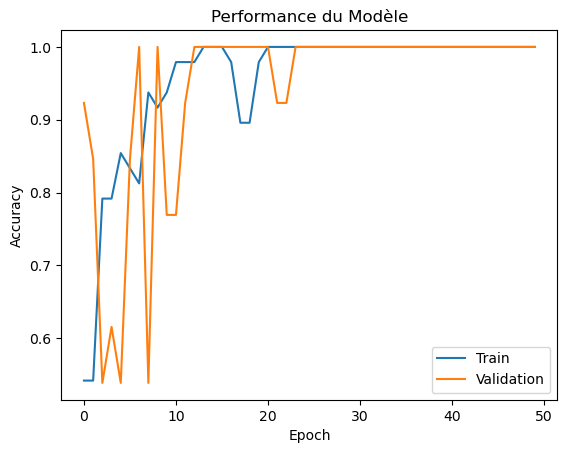

1/1 [==============================] - 3s 3s/step
[[7 0]
 [0 6]]


In [ ]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense
from keras.layers import Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
model = Sequential([
    TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=(SEQUENCE_LENGTH, *IMG_SIZE, 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D()),
    TimeDistributed(Dropout(0.5)),
    TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
    TimeDistributed(GlobalMaxPooling2D()),  # ou Flatten()
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=8,
    callbacks=[EarlyStopping(patience=10, monitor='val_loss')]
)
# Courbes d'apprentissage
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Performance du Modèle')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Matrice de confusion
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print(confusion_matrix(y_true, y_pred))

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# ----------------------------------------
print("\033[94m# Visualisation de l’architecture du modèle Keras\033[0m")
print("\033[94m" + "-"*50 + "\033[0m\n")

# 1. Import des modules nécessaires (fait ci-dessus)

# ----------------------------------------
print("\033[94m# 2. Génération de l’image PNG du modèle\033[0m")
print("\033[94m" + "-"*50 + "\033[0m\n")

# Génère le modèle sous forme d’un fichier PNG avec formes et noms des couches
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# ----------------------------------------
print("\033[94m# 3. Affichage de l’image dans le notebook\033[0m")
print("\033[94m" + "-"*50 + "\033[0m\n")

# Affiche l’image PNG dans le notebook (ou IPython)
display(Image("model.png"))


C:\Users\Alif computer\AppData\Local\Temp\ipykernel_10680\175596281.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


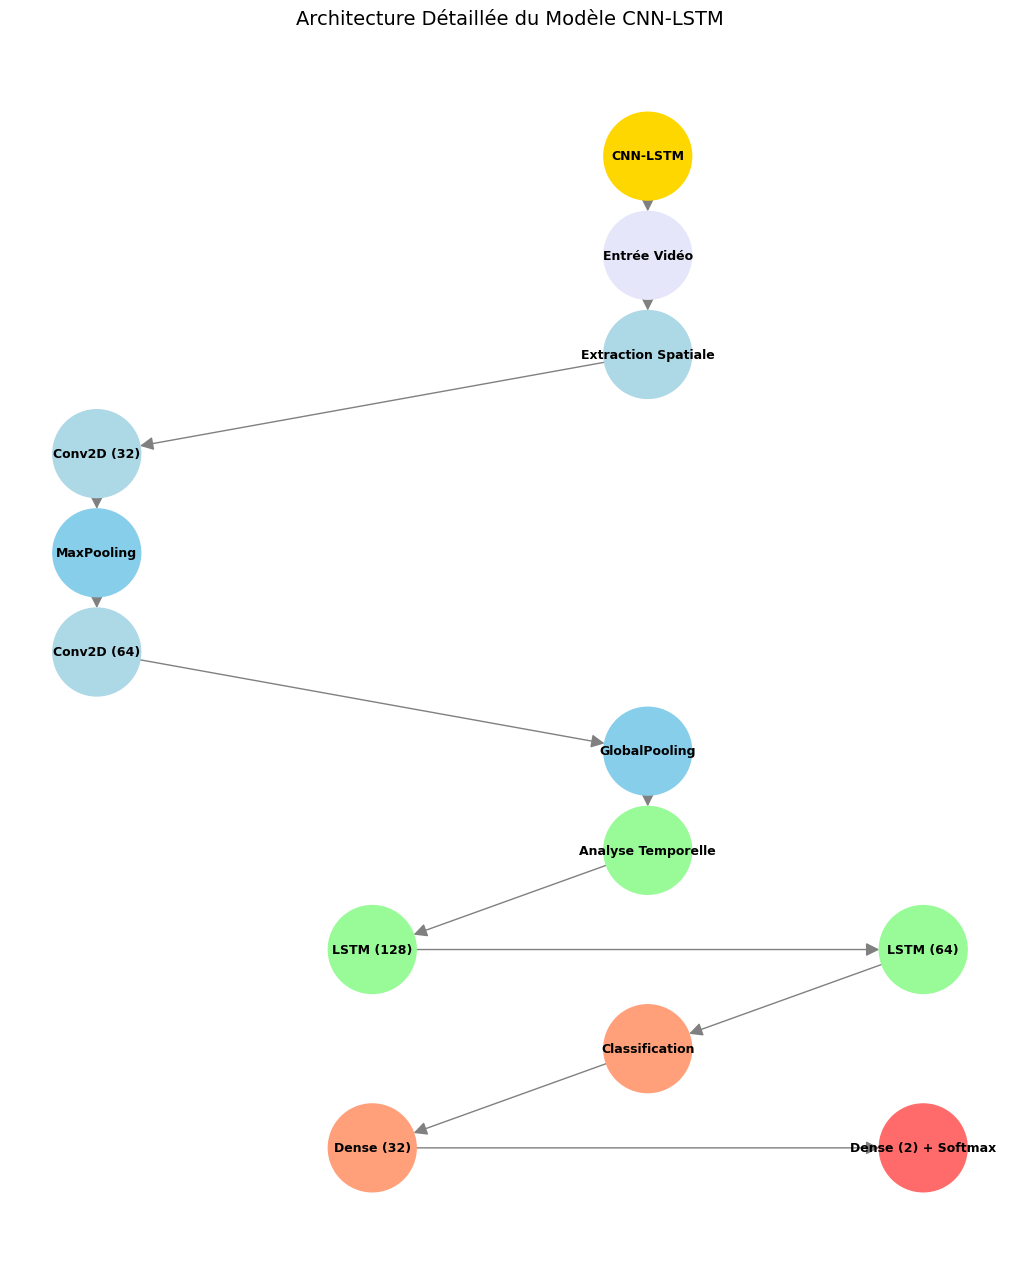

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_detailed_mindmap():
    G = nx.DiGraph()
    G.add_edges_from([
        ("CNN-LSTM", "Entrée Vidéo"),
        ("Entrée Vidéo", "Extraction Spatiale"),
        ("Extraction Spatiale", "Conv2D (32)"),
        ("Conv2D (32)", "MaxPooling"),
        ("MaxPooling", "Conv2D (64)"),
        ("Conv2D (64)", "GlobalPooling"),
        ("GlobalPooling", "Analyse Temporelle"),
        ("Analyse Temporelle", "LSTM (128)"),
        ("LSTM (128)", "LSTM (64)"),
        ("LSTM (64)", "Classification"),
        ("Classification", "Dense (32)"),
        ("Dense (32)", "Dense (2) + Softmax")
    ])
    pos = {
        "CNN-LSTM": (0, 2),
        "Entrée Vidéo": (0, 1.5),
        "Extraction Spatiale": (0, 1),
        "Conv2D (32)": (-1, 0.5),
        "MaxPooling": (-1, 0),
        "Conv2D (64)": (-1, -0.5),
        "GlobalPooling": (0, -1),
        "Analyse Temporelle": (0, -1.5),
        "LSTM (128)": (-0.5, -2),
        "LSTM (64)": (0.5, -2),
        "Classification": (0, -2.5),
        "Dense (32)": (-0.5, -3),
        "Dense (2) + Softmax": (0.5, -3)
    }
    node_colors = {
        "CNN-LSTM": "#FFD700",
        "Entrée Vidéo": "#E6E6FA",
        "Extraction Spatiale": "#ADD8E6",
        "Conv2D (32)": "#ADD8E6",
        "MaxPooling": "#87CEEB",
        "Conv2D (64)": "#ADD8E6",
        "GlobalPooling": "#87CEEB",
        "Analyse Temporelle": "#98FB98",
        "LSTM (128)": "#98FB98", 
        "LSTM (64)": "#98FB98",
        "Classification": "#FFA07A",
        "Dense (32)": "#FFA07A",
        "Dense (2) + Softmax": "#FF6B6B"
    }
    plt.figure(figsize=(10, 12))
    nx.draw(G, pos, 
            with_labels=True,
            node_size=4000,
            node_color=[node_colors[n] for n in G.nodes()],
            font_size=9,
            font_weight='bold',
            arrowsize=20,
            edge_color='gray')
    plt.title("Architecture Détaillée du Modèle CNN-LSTM", fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()

draw_detailed_mindmap()

In [ ]:
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv2D, MaxPooling2D, LSTM, Dense
from keras.layers import Dropout, BatchNormalization, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.regularizers import l2
from keras.optimizers import Adam
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
SEQUENCE_LENGTH = 30 
IMG_SIZE = (128, 128)   
BATCH_SIZE = 16      
class_weights = class_weight.compute_class_weight('balanced', 
                                                classes=np.unique(np.argmax(y_train, axis=1)), 
                                                y=np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))
model = Sequential([
    TimeDistributed(Conv2D(64, (3, 3), activation='relu', padding='same', 
                      kernel_regularizer=l2(0.01)), 
    input_shape=(SEQUENCE_LENGTH, *IMG_SIZE, 3)),
    TimeDistributed(BatchNormalization()),
    TimeDistributed(MaxPooling2D((2, 2))),
    TimeDistributed(Dropout(0.4)),  
    TimeDistributed(Conv2D(128, (3, 3), activation='relu', padding='same',
                      kernel_regularizer=l2(0.01))),
    TimeDistributed(GlobalMaxPooling2D()),
    LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),  
    Dense(2, activation='softmax')
])
optimizer = Adam(learning_rate=0.0001)  
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', 'Recall'])  
callbacks = [
    EarlyStopping(monitor='val_recall', patience=15, mode='max', 
                 restore_best_weights=True),
    ModelCheckpoint('best_fall_detection1.h5', monitor='val_recall', 
                  save_best_only=True),
    ReduceLROnPlateau(monitor='val_recall', factor=0.2, patience=5, min_lr=1e-6)
]
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,  
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    class_weight=class_weights  
)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy au Cours de l\'Entraînement')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Rappel (Recall) au Cours de l\'Entraînement')
plt.legend()
plt.show()
from sklearn.metrics import classification_report, confusion_matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
print("Matrice de Confusion:")
print(confusion_matrix(y_true, y_pred))
print("\nRapport de Classification:")
print(classification_report(y_true, y_pred, target_names=["Non-Chute", "Chute"]))

Epoch 1/100
4/4 [==============================] - 436s 86s/step - loss: 2.2066 - accuracy: 0.5789 - recall: 0.5789 - val_loss: 2.3018 - val_accuracy: 0.2500 - val_recall: 0.2500 - lr: 1.0000e-04
Epoch 2/100
4/4 [==============================] - 354s 80s/step - loss: 2.2111 - accuracy: 0.5965 - recall: 0.5965 - val_loss: 2.3031 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/100
4/4 [==============================] - 324s 78s/step - loss: 2.1894 - accuracy: 0.6140 - recall: 0.6140 - val_loss: 2.2967 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/100
4/4 [==============================] - 412s 87s/step - loss: 2.2319 - accuracy: 0.4912 - recall: 0.4912 - val_loss: 2.2692 - val_accuracy: 0.5000 - val_recall: 0.5000 - lr: 1.0000e-04
Epoch 5/100
4/4 [==============================] - 350s 82s/step - loss: 2.1851 - accuracy: 0.5789 - recall: 0.5789 - val_loss: 2.2507 - val_accuracy: 0.5000 - val_recall: 0.5000 - lr: 1.0000e-04
Epoc

In [4]:
model.save('fall_prediction_model.h5')

🧠 test sur une video

In [5]:
import cv2
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt

# === PARAMÈTRES ===
IMG_SIZE = (128, 128)
SEQUENCE_LENGTH = 30
CLASSES = ['Fall', 'No Fall']
VIDEO_PATH = r"../data/datatest/testAlgorithme1/videotest2.mp4"
MODEL_PATH = "best_fall_detection.h5"

# === CHARGER LE MODÈLE ===
model = load_model(MODEL_PATH)
print("Modèle chargé avec succès.")
model.summary()

# === EXTRAIRE FRAMES ===
def extract_frames(video_path, seq_length=SEQUENCE_LENGTH, img_size=IMG_SIZE):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while len(frames) < seq_length:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, img_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  
        frames.append(frame)
    cap.release()
    if len(frames) < seq_length:
        print(f"Vidéo trop courte ({len(frames)} frames, besoin de {seq_length})")
        return None
    frames = np.array(frames) / 255.0
    frames = np.expand_dims(frames[:seq_length], axis=0) 
    print("Forme de l'entrée pour le modèle :", frames.shape)
    return frames
# === FAIRE UNE PRÉDICTION ===
def predict_video(video_path):
    sequence = extract_frames(video_path)
    if sequence is None:
        return
    prediction = model.predict(sequence)
    predicted_class = CLASSES[np.argmax(prediction)]
    print("Prédiction :", predicted_class)
    print("Probabilités :", prediction[0])
    # Affichage vidéo
    sequence_np = (sequence[0] * 255).astype(np.uint8)
    for frame in sequence_np:
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.putText(frame_bgr, f"Prediction: {predicted_class}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.imshow("Video Prediction", frame_bgr)
        if cv2.waitKey(100) & 0xFF == ord('q'):
            break
    cv2.destroyAllWindows()
# === LANCER LA PRÉDICTION ===
predict_video(VIDEO_PATH)

Modèle chargé avec succès.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 30, 128, 128, 64)  1792     
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 128, 128, 64)  256      
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 30, 64, 64, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 64, 64, 64)   0         
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeD